# Part 3: ALICES baseline analysis

## Preparations

In [1]:
%matplotlib inline

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import sys
from scipy.stats import norm

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

sys.path.append("/Users/johannbrehmer/work/projects/madminer/madminer")
from madminer.sampling import SampleAugmenter
from madminer import sampling
from madminer.ml import ParameterizedRatioEstimator

sys.path.append("/Users/johannbrehmer/work/projects/manifold_flow/manifold-flow")
from experiments.evaluation import mcmc

for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)
        


10:09 madminer             INFO    
10:09 madminer             INFO    ------------------------------------------------------------------------
10:09 madminer             INFO    |                                                                      |
10:09 madminer             INFO    |  MadMiner v0.7.1                                                     |
10:09 madminer             INFO    |                                                                      |
10:09 madminer             INFO    |         Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer  |
10:09 madminer             INFO    |                                                                      |
10:09 madminer             INFO    ------------------------------------------------------------------------
10:09 madminer             INFO    
10:09 experiments.training WARNING geomloss not found, let's hope that you started a training method that doesn't need it!


## Generate training data

In [2]:
sampler = SampleAugmenter('data/delphes_data.h5')

10:09 madminer.analysis.da INFO    Loading data from data/delphes_data.h5
10:09 madminer.analysis.da INFO    Found 2 parameters
10:09 madminer.analysis.da INFO    Did not find nuisance parameters
10:09 madminer.analysis.da INFO    Found 6 benchmarks, of which 6 physical
10:09 madminer.analysis.da INFO    Found 48 observables
10:09 madminer.analysis.da INFO    Found 630610 events
10:09 madminer.analysis.da INFO      105696 signal events sampled from benchmark morphing_basis_vector_0
10:09 madminer.analysis.da INFO      101737 signal events sampled from benchmark morphing_basis_vector_1
10:09 madminer.analysis.da INFO      106743 signal events sampled from benchmark morphing_basis_vector_2
10:09 madminer.analysis.da INFO      102700 signal events sampled from benchmark morphing_basis_vector_3
10:09 madminer.analysis.da INFO      104279 signal events sampled from benchmark morphing_basis_vector_4
10:09 madminer.analysis.da INFO      109455 signal events sampled from benchmark morphing_bas

In [3]:
x, theta0, theta1, y, r_xz, t_xz, n_effective = sampler.sample_train_ratio(
    theta0=sampling.random_morphing_points(1000, [('gaussian', 0., 1.0), ('gaussian', 0., 1.0)]),
    theta1=sampling.morphing_point([0.,0.]),
    n_samples=1000000,
    folder='./data/samples',
    filename='train_ratio',
    sample_only_from_closest_benchmark=True,
    return_individual_n_effective=True,
)

18:30 madminer.sampling    INFO    Extracting training sample for ratio-based methods. Numerator hypothesis: 1000 random morphing points, drawn from the following priors:
  theta_0 ~ Gaussian with mean 0.0 and std 1.0
  theta_1 ~ Gaussian with mean 0.0 and std 1.0, denominator hypothesis: [0. 0.]
18:30 madminer.sampling    INFO    Starting sampling serially
18:30 madminer.sampling    INFO    Sampling from parameter point 50 / 1000
18:30 madminer.sampling    WARNING Large statistical uncertainty on the total cross section when sampling from theta = [ 0.39923188 -0.23322676]: (0.003817 +/- 0.000416) pb (10.895047869081584 %). Skipping these warnings in the future...
18:31 madminer.sampling    INFO    Sampling from parameter point 100 / 1000
18:31 madminer.sampling    INFO    Sampling from parameter point 150 / 1000
18:31 madminer.sampling    INFO    Sampling from parameter point 200 / 1000
18:31 madminer.sampling    INFO    Sampling from parameter point 250 / 1000
18:32 madminer.sampling

## Train likelihood ratio estimators with ALICES method

In [7]:
for i in range(5,10):
    logging.info("Let's go run %s!", i + 1)
    
    estimator = ParameterizedRatioEstimator(
        n_hidden=(100, 100, 100,),
        activation="tanh"
    )
    estimator.train(
        method='alices',
        theta='data/samples/theta0_train_ratio.npy',
        x='data/samples/x_train_ratio.npy',
        y='data/samples/y_train_ratio.npy',
        r_xz='data/samples/r_xz_train_ratio.npy',
        t_xz='data/samples/t_xz_train_ratio.npy',
        alpha=1.,
        n_epochs=50,
    )
    estimator.save('models/alices{}'.format("" if i == 0 else "_run{}".format(i)))
    

10:11 root                 INFO    Let's go run 6!
10:43 root                 INFO    Let's go run 7!
11:17 root                 INFO    Let's go run 8!
11:51 root                 INFO    Let's go run 9!
12:27 root                 INFO    Let's go run 10!


## Evaluate likelihood ratio on grid

In [12]:
theta_each = np.linspace(-1,1,11)
theta0, theta1 = np.meshgrid(theta_each, theta_each)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T
np.save('data/samples/theta_grid.npy', theta_grid)


In [13]:
estimator.load('models/alices')

log_r_hat, _ = estimator.evaluate_log_likelihood_ratio(
    theta='data/samples/theta_grid.npy',
    x='data/samples/x_test.npy',
    evaluate_score=False
)

20:02 madminer.ml          INFO    Loading model from models/alices
20:02 madminer.ml          INFO    Loading evaluation data
20:02 madminer.utils.vario INFO      Loading data/samples/x_test.npy into RAM
20:02 madminer.utils.vario INFO      Loading data/samples/theta_grid.npy into RAM
20:02 madminer.ml          INFO    Starting ratio evaluation for 1210000 x-theta combinations
20:02 madminer.ml          INFO    Evaluation done


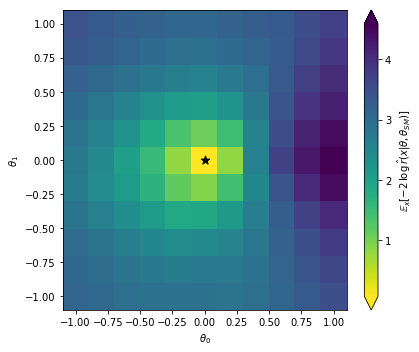

In [15]:
bin_size = theta_each[1] - theta_each[0]
edges = np.linspace(theta_each[0] - bin_size/2, theta_each[-1] + bin_size/2, len(theta_each)+1)

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

expected_llr = np.mean(log_r_hat,axis=1)
best_fit = theta_grid[np.argmin(-2.*expected_llr)]

cmin, cmax = np.min(-2*expected_llr), np.max(-2*expected_llr)
    
pcm = ax.pcolormesh(edges, edges, -2. * expected_llr.reshape((11,11)),
                    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
                    cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(best_fit[0], best_fit[1], s=80., color='black', marker='*')

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label(r'$\mathbb{E}_x [ -2\, \log \,\hat{r}(x | \theta, \theta_{SM}) ]$')

plt.tight_layout()
plt.show()


## Run MCMC

In [8]:
for key in logging.Logger.manager.loggerDict:
    if "madminer" in key:
        logging.getLogger(key).setLevel(logging.WARNING)
    if "mcmc" in key:
        logging.getLogger(key).setLevel(logging.INFO)

In [9]:
def run_mcmc(run=0, trueparam=0, chain=0, observedsamples=50, mcmcsamples=750, mcmcstep=0.15, burnin=100, thin=1):
    run_str = "" if run == 0 else "_run{}".format(run)
    trueparam_str = "" if trueparam == 0 else "_trueparam{}".format(trueparam)
    chain_str = "" if chain == 0 else "_chain{}".format(chain)
    
    # Model
    estimator = ParameterizedRatioEstimator(
        n_hidden=(100, 100, 100),
        activation="tanh"
    )
    estimator.load('models/alices{}'.format(run_str))

    # Data
    theta_true = np.load("data/samples/theta_test{}.npy".format("" if trueparam == 0 else trueparam))[0]
    x_obs = np.load("data/samples/x_test{}.npy".format("" if trueparam == 0 else trueparam))[:observedsamples]

    # MCMC based on neural likelihood estimator
    def log_posterior(params):
        params_ = np.broadcast_to(params.reshape((-1, params.shape[-1])), (x_obs.shape[0], params.shape[-1]))

        # Likelihood ratio
        log_likelihood_ratios = estimator.evaluate_log_likelihood_ratio(
            theta=params_,
            x=x_obs,
            evaluate_score=False,
            test_all_combinations=False
        )[0]
        log_prob = np.sum(log_likelihood_ratios)

        # Prior
        log_prob += np.sum(norm(loc=0.0, scale=1.0).logpdf(x=params))
        return float(log_prob)

    sampler = mcmc.GaussianMetropolis(theta_true, log_posterior, step=mcmcstep, thin=thin)

    if burnin > 0:
        logging.info("Starting burn in")
        sampler.gen(burnin)
    logging.info("Burn in done, starting main chain")
    posterior_samples = sampler.gen(mcmcsamples)
    logging.info("MCMC done")
    
    np.save(
        "../../data/results/alices_14_lhc_may{}_posterior_samples{}{}.npy".format(run_str, trueparam_str, chain_str),
        posterior_samples
    )

    return posterior_samples

In [10]:
posterior_samples = []

for run in range(5,10):
    for trueparam in range(3):
        for chain in range(4):
            run_mcmc(run, trueparam, chain)


13:12 root                 INFO    Starting burn in
13:12 experiments.evaluati INFO    MCMC after sample 100 = [0.07074368 0.05568243]: acceptance rate = 0.05, log likelihood = -1.66
13:12 experiments.evaluati INFO    MCMC chain finished after 100 samples: acceptance rate = 0.05, log likelihood = -1.66
13:12 root                 INFO    Burn in done, starting main chain
13:12 experiments.evaluati INFO    MCMC after sample 100 = [0.04834398 0.02856567]: acceptance rate = 0.03, log likelihood = 0.64
13:12 experiments.evaluati INFO    MCMC after sample 200 = [0.04688634 0.03771379]: acceptance rate = 0.05, log likelihood = 0.45
13:12 experiments.evaluati INFO    MCMC after sample 300 = [0.05047088 0.04438401]: acceptance rate = 0.05, log likelihood = 0.09
13:12 experiments.evaluati INFO    MCMC after sample 400 = [0.03834638 0.05532829]: acceptance rate = 0.04, log likelihood = -0.43
13:12 experiments.evaluati INFO    MCMC after sample 500 = [0.07199873 0.03179857]: acceptance rate = 0.05

13:13 experiments.evaluati INFO    MCMC after sample 600 = [0.41489039 0.05807723]: acceptance rate = 0.17, log likelihood = 92.81
13:13 experiments.evaluati INFO    MCMC after sample 700 = [0.41864848 0.07946956]: acceptance rate = 0.17, log likelihood = 93.10
13:13 experiments.evaluati INFO    MCMC chain finished after 750 samples: acceptance rate = 0.17, log likelihood = 92.39
13:13 root                 INFO    MCMC done
13:13 root                 INFO    Starting burn in
13:13 experiments.evaluati INFO    MCMC after sample 100 = [0.40373794 0.15231302]: acceptance rate = 0.20, log likelihood = 92.47
13:13 experiments.evaluati INFO    MCMC chain finished after 100 samples: acceptance rate = 0.20, log likelihood = 92.47
13:13 root                 INFO    Burn in done, starting main chain
13:13 experiments.evaluati INFO    MCMC after sample 100 = [0.4092194  0.09035109]: acceptance rate = 0.12, log likelihood = 93.18
13:13 experiments.evaluati INFO    MCMC after sample 200 = [0.352619

13:13 experiments.evaluati INFO    MCMC after sample 200 = [-0.86744701 -1.01741506]: acceptance rate = 0.69, log likelihood = 87.08
13:13 experiments.evaluati INFO    MCMC after sample 300 = [-0.8704429  -0.76858234]: acceptance rate = 0.66, log likelihood = 87.63
13:13 experiments.evaluati INFO    MCMC after sample 400 = [-0.99426855 -1.20978919]: acceptance rate = 0.63, log likelihood = 86.27
13:13 experiments.evaluati INFO    MCMC after sample 500 = [-0.52165769 -0.94019555]: acceptance rate = 0.64, log likelihood = 86.03
13:13 experiments.evaluati INFO    MCMC after sample 600 = [-0.99751331 -0.94674536]: acceptance rate = 0.63, log likelihood = 87.22
13:13 experiments.evaluati INFO    MCMC after sample 700 = [-0.488708   -0.64421137]: acceptance rate = 0.62, log likelihood = 88.00
13:13 experiments.evaluati INFO    MCMC chain finished after 750 samples: acceptance rate = 0.62, log likelihood = 87.53
13:13 root                 INFO    MCMC done
13:13 root                 INFO    S

13:13 root                 INFO    MCMC done
13:13 root                 INFO    Starting burn in
13:13 experiments.evaluati INFO    MCMC after sample 100 = [0.4440731  0.18655504]: acceptance rate = 0.22, log likelihood = 88.41
13:13 experiments.evaluati INFO    MCMC chain finished after 100 samples: acceptance rate = 0.22, log likelihood = 88.41
13:13 root                 INFO    Burn in done, starting main chain
13:13 experiments.evaluati INFO    MCMC after sample 100 = [0.33626077 0.13605726]: acceptance rate = 0.25, log likelihood = 87.36
13:13 experiments.evaluati INFO    MCMC after sample 200 = [0.39566297 0.05811499]: acceptance rate = 0.23, log likelihood = 87.53
13:13 experiments.evaluati INFO    MCMC after sample 300 = [0.43399975 0.27655396]: acceptance rate = 0.25, log likelihood = 87.00
13:13 experiments.evaluati INFO    MCMC after sample 400 = [0.4692156  0.12408679]: acceptance rate = 0.25, log likelihood = 88.40
13:13 experiments.evaluati INFO    MCMC after sample 500 =

13:13 experiments.evaluati INFO    MCMC after sample 500 = [-0.67311235 -0.66462753]: acceptance rate = 0.61, log likelihood = 90.65
13:13 experiments.evaluati INFO    MCMC after sample 600 = [-0.35710145 -0.42882432]: acceptance rate = 0.61, log likelihood = 89.49
13:13 experiments.evaluati INFO    MCMC after sample 700 = [-1.10324119 -0.78390431]: acceptance rate = 0.61, log likelihood = 89.91
13:13 experiments.evaluati INFO    MCMC chain finished after 750 samples: acceptance rate = 0.61, log likelihood = 89.33
13:13 root                 INFO    MCMC done
13:13 root                 INFO    Starting burn in
13:13 experiments.evaluati INFO    MCMC after sample 100 = [-1.40639927 -1.48242648]: acceptance rate = 0.67, log likelihood = 87.74
13:13 experiments.evaluati INFO    MCMC chain finished after 100 samples: acceptance rate = 0.67, log likelihood = 87.74
13:13 root                 INFO    Burn in done, starting main chain
13:13 experiments.evaluati INFO    MCMC after sample 100 = [

13:13 experiments.evaluati INFO    MCMC after sample 100 = [0.33221177 0.15117171]: acceptance rate = 0.18, log likelihood = 89.48
13:13 experiments.evaluati INFO    MCMC after sample 200 = [0.40658283 0.06248408]: acceptance rate = 0.23, log likelihood = 88.48
13:13 experiments.evaluati INFO    MCMC after sample 300 = [0.42990366 0.13117572]: acceptance rate = 0.22, log likelihood = 89.23
13:13 experiments.evaluati INFO    MCMC after sample 400 = [0.27855533 0.11625913]: acceptance rate = 0.22, log likelihood = 87.21
13:13 experiments.evaluati INFO    MCMC after sample 500 = [0.40153325 0.11351061]: acceptance rate = 0.23, log likelihood = 89.48
13:13 experiments.evaluati INFO    MCMC after sample 600 = [0.38705854 0.16389653]: acceptance rate = 0.22, log likelihood = 89.81
13:13 experiments.evaluati INFO    MCMC after sample 700 = [0.4078851  0.14582083]: acceptance rate = 0.23, log likelihood = 89.64
13:13 experiments.evaluati INFO    MCMC chain finished after 750 samples: acceptanc

13:14 experiments.evaluati INFO    MCMC chain finished after 750 samples: acceptance rate = 0.67, log likelihood = 88.53
13:14 root                 INFO    MCMC done
13:14 root                 INFO    Starting burn in
13:14 experiments.evaluati INFO    MCMC after sample 100 = [-0.84755017 -0.58732992]: acceptance rate = 0.58, log likelihood = 87.97
13:14 experiments.evaluati INFO    MCMC chain finished after 100 samples: acceptance rate = 0.58, log likelihood = 87.97
13:14 root                 INFO    Burn in done, starting main chain
13:14 experiments.evaluati INFO    MCMC after sample 100 = [-1.1922187  -1.17072937]: acceptance rate = 0.54, log likelihood = 88.12
13:14 experiments.evaluati INFO    MCMC after sample 200 = [-0.55861146 -0.31358057]: acceptance rate = 0.59, log likelihood = 84.55
13:14 experiments.evaluati INFO    MCMC after sample 300 = [-1.05085597 -0.96841672]: acceptance rate = 0.52, log likelihood = 88.53
13:14 experiments.evaluati INFO    MCMC after sample 400 = [

13:14 experiments.evaluati INFO    MCMC after sample 400 = [0.04302027 0.00836442]: acceptance rate = 0.03, log likelihood = -1.72
13:14 experiments.evaluati INFO    MCMC after sample 500 = [0.02215919 0.04826389]: acceptance rate = 0.03, log likelihood = -2.66
13:14 experiments.evaluati INFO    MCMC after sample 600 = [0.05806857 0.04111941]: acceptance rate = 0.03, log likelihood = -2.35
13:14 experiments.evaluati INFO    MCMC after sample 700 = [0.05890915 0.01676064]: acceptance rate = 0.04, log likelihood = -1.92
13:14 experiments.evaluati INFO    MCMC chain finished after 750 samples: acceptance rate = 0.04, log likelihood = -2.13
13:14 root                 INFO    MCMC done
13:14 root                 INFO    Starting burn in
13:14 experiments.evaluati INFO    MCMC after sample 100 = [0.39124986 0.10754982]: acceptance rate = 0.44, log likelihood = 95.96
13:14 experiments.evaluati INFO    MCMC chain finished after 100 samples: acceptance rate = 0.44, log likelihood = 95.96
13:14 

13:14 root                 INFO    Burn in done, starting main chain
13:14 experiments.evaluati INFO    MCMC after sample 100 = [-0.77370953 -0.7697832 ]: acceptance rate = 0.57, log likelihood = 92.88
13:14 experiments.evaluati INFO    MCMC after sample 200 = [-0.37176719 -0.87507741]: acceptance rate = 0.65, log likelihood = 86.61
13:14 experiments.evaluati INFO    MCMC after sample 300 = [-0.9759462  -1.25067062]: acceptance rate = 0.66, log likelihood = 91.44
13:14 experiments.evaluati INFO    MCMC after sample 400 = [-1.53478414 -1.1058229 ]: acceptance rate = 0.69, log likelihood = 90.26
13:14 experiments.evaluati INFO    MCMC after sample 500 = [-1.43129535 -1.22210739]: acceptance rate = 0.71, log likelihood = 90.99
13:14 experiments.evaluati INFO    MCMC after sample 600 = [-1.3345877  -0.99092707]: acceptance rate = 0.72, log likelihood = 90.97
13:14 experiments.evaluati INFO    MCMC after sample 700 = [-0.91227103 -0.85220093]: acceptance rate = 0.71, log likelihood = 92.64


13:14 experiments.evaluati INFO    MCMC chain finished after 750 samples: acceptance rate = 0.06, log likelihood = -2.25
13:14 root                 INFO    MCMC done
13:14 root                 INFO    Starting burn in
13:14 experiments.evaluati INFO    MCMC after sample 100 = [0.03328635 0.02937282]: acceptance rate = 0.04, log likelihood = -0.02
13:14 experiments.evaluati INFO    MCMC chain finished after 100 samples: acceptance rate = 0.04, log likelihood = -0.02
13:14 root                 INFO    Burn in done, starting main chain
13:14 experiments.evaluati INFO    MCMC after sample 100 = [0.03328635 0.02937282]: acceptance rate = 0.00, log likelihood = -0.02
13:14 experiments.evaluati INFO    MCMC after sample 200 = [ 0.04845324 -0.00289306]: acceptance rate = 0.04, log likelihood = -0.42
13:14 experiments.evaluati INFO    MCMC after sample 300 = [0.0546563  0.01700362]: acceptance rate = 0.03, log likelihood = 0.12
13:14 experiments.evaluati INFO    MCMC after sample 400 = [0.04609

13:15 experiments.evaluati INFO    MCMC after sample 400 = [-0.52284945 -0.34086028]: acceptance rate = 0.58, log likelihood = 78.38
13:15 experiments.evaluati INFO    MCMC after sample 500 = [-0.50564926 -0.52154476]: acceptance rate = 0.61, log likelihood = 80.23
13:15 experiments.evaluati INFO    MCMC after sample 600 = [-0.96365285 -1.17200472]: acceptance rate = 0.62, log likelihood = 78.51
13:15 experiments.evaluati INFO    MCMC after sample 700 = [-1.48820129 -0.97737336]: acceptance rate = 0.63, log likelihood = 77.78
13:15 experiments.evaluati INFO    MCMC chain finished after 750 samples: acceptance rate = 0.64, log likelihood = 78.34
13:15 root                 INFO    MCMC done
13:15 root                 INFO    Starting burn in
13:15 experiments.evaluati INFO    MCMC after sample 100 = [-0.95092616 -1.19534899]: acceptance rate = 0.48, log likelihood = 78.39
13:15 experiments.evaluati INFO    MCMC chain finished after 100 samples: acceptance rate = 0.48, log likelihood = 78